## Project: **Finding Lane Lines on the Road** 
***
### The objective of this project is to identify lane lines on the road using combination of tools learnt in Lesson 1 (color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection). 
---
Let's perform lane detection on 'test_images/solidYellowCurve2.jpg'
This image has a yellow and white lane lines to help us optimize for both types of lane lines

## Import Packages
***
### Importing all the prerequisite packages
---

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import cv2
from PIL import Image
import math
import fnmatch
%matplotlib inline

### Start with importing and plotting the test image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


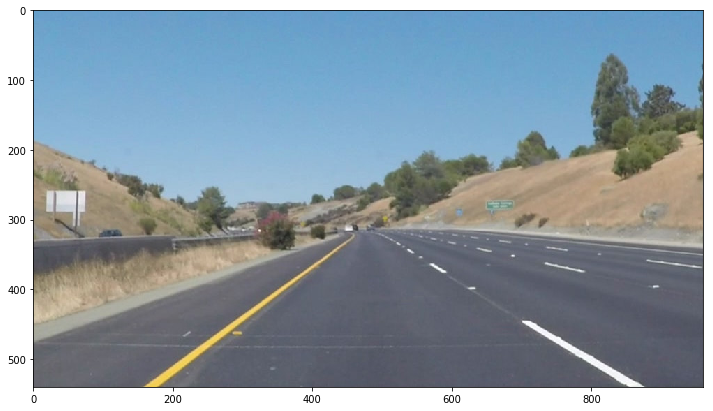

In [2]:
image = mpimg.imread('test_images/solidYellowCurve2.jpg')
print('This image is:', type(image), 'with dimensions:', image.shape)
#printing out some stats and plotting
fig = plt.figure(figsize=(12,13))
plt.imshow(image) 

The image is a 3 channel colored image with dimensions 540 x 960 


### Colorspaces and applying thresholds
From [1] and [2], it can be inferred that detecting white is fairly easy in HSL colorspace.
Function gotohls converts the RGB image to HLS image
and function ident_white_yellow applies threshold to extract yellow and white colors from the original image

[1] https://en.wikipedia.org/wiki/HSL_and_HSV
[2] http://stackoverflow.com/questions/22588146/tracking-white-color-using-python-opencv 
    'You might also consider using HSL color space, which stands for Hue, Saturation, Lightness. Then you would only have to look at lightness for detecting white and recognizing other colors would stay easy.'


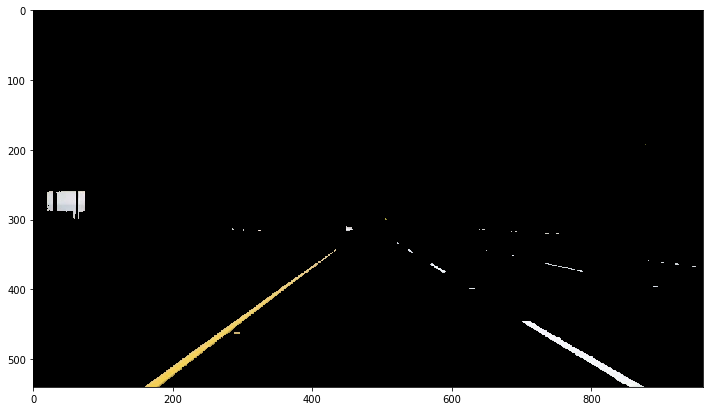

In [3]:
def gotohls(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

def ident_white_yellow(img): 
    hls_image = gotohls(img)
    lower_bound = np.uint8([  0, 200,   0])
    upper_bound = np.uint8([255, 255, 255])
    white_lines = cv2.inRange(hls_image, lower_bound, upper_bound)
    lower_bound = np.uint8([ 10,   0, 100])
    upper_bound = np.uint8([ 40, 255, 255])
    yellow_lines = cv2.inRange(hls_image, lower_bound, upper_bound)
    masked = cv2.bitwise_or(white_lines, yellow_lines)
    return cv2.bitwise_and(img, img, mask = masked)
# Display the image
fig = plt.figure(figsize=(12,13))
colored_img = ident_white_yellow(image)
plt.imshow(colored_img)
export_image = Image.fromarray(colored_img)
export_image.save("readme_ref/_colored_img.jpeg")

## Applying gray scale filter
From [3] it makes sense to apply gray scale filter on our image so that the thresholds for Canny Edge Detection are reasonable values in tens or hundreds. 

[3] Lesson 1, Chapter 11 - 'What would make sense as a reasonable range for these parameters? In our case, converting to grayscale has left us with an 8-bit image, so each pixel can take 2^8 = 256 possible values. Hence, the pixel values range from 0 to 255.' 

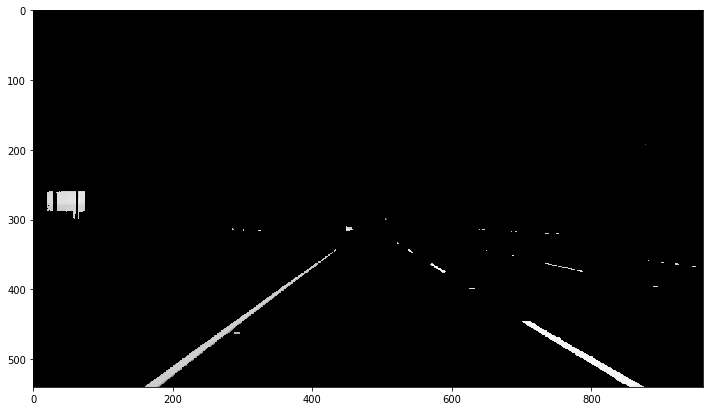

In [4]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray_image = grayscale(colored_img)
fig = plt.figure(figsize=(12,13))
plt.imshow(gray_image, cmap='gray')
export_image = Image.fromarray(gray_image)
export_image.save("readme_ref/gray_image.jpeg")

## Applying Gaussian Blur
Gaussian Blurring smoothens a given image. Averaging functions like Gaussian Blur helps eliminate sudden spikes and remove noise to a certain extent. Kernel size of 9 seemed optimal based on the output, the image still has distinct edges and is not completely blurred. 

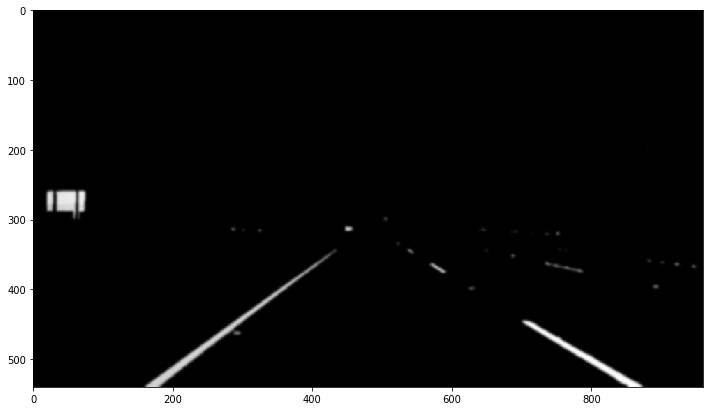

In [5]:
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

kernel_size = 9
blur_gray = gaussian_blur(gray_image,kernel_size)
fig = plt.figure(figsize=(12,13))
plt.imshow(blur_gray, cmap='gray')
export_image = Image.fromarray(blur_gray)
export_image.save("readme_ref/blur_gray.jpeg")

## Applying Canny Edge Detection 
Using low_threshold = 50 and high_threshold = 150, the edges on the given image are identified using cv2.Canny 

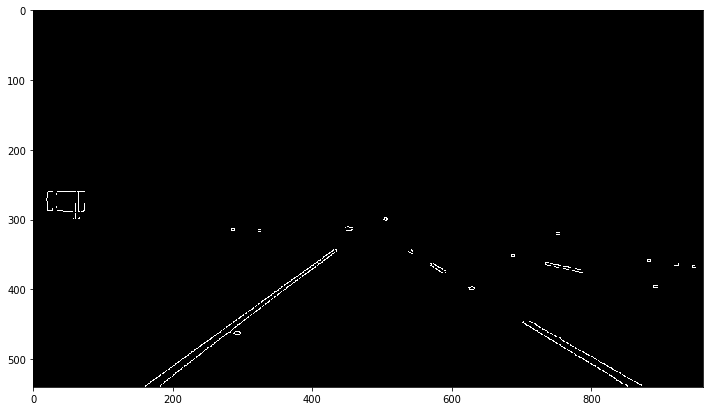

In [6]:
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)
low_threshold = 50
high_threshold = 150
edges = canny(blur_gray, low_threshold, high_threshold)
fig = plt.figure(figsize=(12,13))
plt.imshow(edges, cmap='gray')
export_image = Image.fromarray(edges)
export_image.save("readme_ref/edges.jpeg")

## Selecting region of interest and applying masking
Using the helper function 'region of interest', a polygon is defined such that other objects are ignored (eg. adjacent lanes, trees, traffic signs).

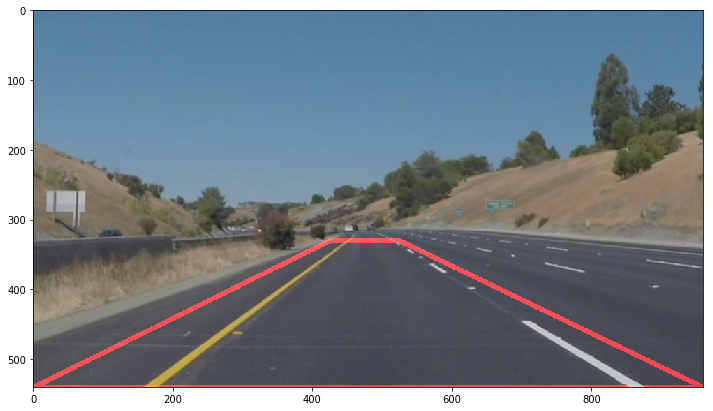

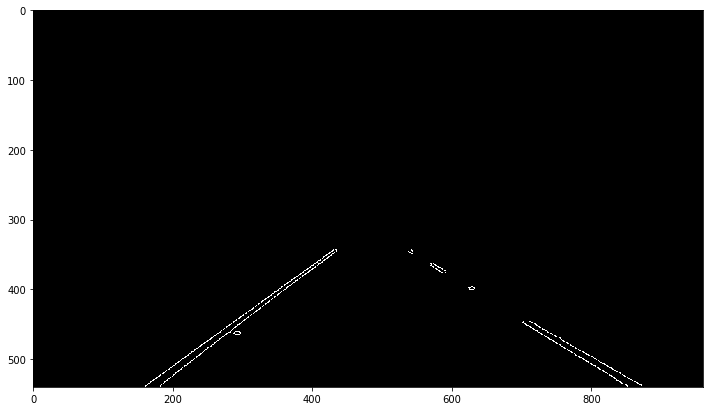

In [7]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

imshape = image.shape
vertices = np.array([[(0,imshape[0]),(425, 330), (525, 330), (imshape[1],imshape[0])]], dtype=np.int32)
masked_edges = region_of_interest(edges, vertices)
fig = plt.figure(figsize=(12,13))
plt.imshow(image)
x = [0, 425 , 525 , imshape[1],0]
y = [imshape[0], 330,330,imshape[0],imshape[0]]
#plt.plot(x, y, 'r', lw=3)
overlayed_image1 = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
overlayed_image1 = cv2.line(overlayed_image1, (x[0], y[0]), (x[1], y[1]), color=[255, 0, 0], thickness=5)
overlayed_image1 = cv2.line(overlayed_image1, (x[1], y[1]), (x[2], y[2]), color=[255, 0, 0], thickness=5)
overlayed_image1 = cv2.line(overlayed_image1, (x[2], y[2]), (x[3], y[3]), color=[255, 0, 0], thickness=5)
overlayed_image1 = cv2.line(overlayed_image1, (x[3], y[3]), (x[4], y[4]), color=[255, 0, 0], thickness=5)
overlayed_image1 = cv2.addWeighted(image, 0.8, overlayed_image1, 1, 0.0)
plt.imshow(overlayed_image1)
export_image = Image.fromarray(overlayed_image1)
export_image.save("readme_ref/region_of_interest_red.jpeg")
fig = plt.figure(figsize=(12,13))
plt.imshow(masked_edges, cmap='gray')
export_image = Image.fromarray(masked_edges)
export_image.save("readme_ref/masked_edges.jpeg")

Above images show the highlighted area (red box) as our region of interest and after applying this mask on Canny's output, we are able to keep the left and the right lanes in our final image. 



## Identifying Lines using Hough Transform
Hough Transform is used to convert lines from x vs y coordinate system to m vs b system. 
This transform is applied here to efficiently identify the lanes from an image and store the m,b in an array. 
Hough Transform is driven by multiple parameters used to identify the lines. 
Distance resolution in pixels of the Hough grid was 1
Angular resolution in radians of the Hough grid was 1 deg or pi/180 rad
I have tweaked the intersection threshold, minimum number of pixels making up a line and maximum gap in pixels between connectable line segments such that all six test images are identified correctly.


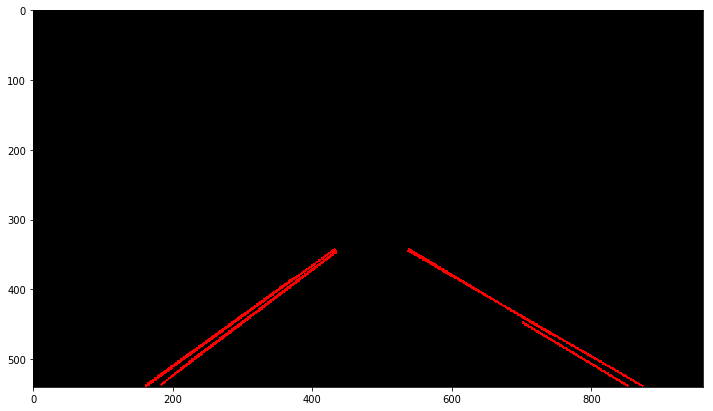

In [8]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold =  35 # 15 worked    # minimum number of votes (intersections in Hough grid cell)
min_line_len = 50  #minimum number of pixels making up a line
max_line_gap = 200    # maximum gap in pixels between connectable line segments
lane_sketched = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)
fig = plt.figure(figsize=(12,13))
plt.imshow(lane_sketched)
export_image = Image.fromarray(lane_sketched)
export_image.save("readme_ref/lane_sketched.jpeg")

### Modifying the Draw Lines Function to implement averaging, interpolating and extrapolating
The output of Hough Transform are lines stored in an array. We iterate through this array and convert the x,y to m,b. Based on the value of slope i.e. positive or negative, the m,b value is stored in left_line or right_line. The slope and intercepts of the  lines are then averaged using np.mean function, since averaging helps in finding center of the detected line. The average_of_lines  performs averaging. After averaging, the averaged slope and intercept values are used to draw a line roughly to cover some part of the image. 65% of y axis was chosen since the road in most of the images covers at least 65% of the image. 
Based on the averaged slope and intercepts, and a known upper and lower y limit, x values are obtained. This results in a continuous lines obtained from averaging the output of Hough Lines. The resultant lines are then combined with the original image using the helper function 'weighted_img'. 

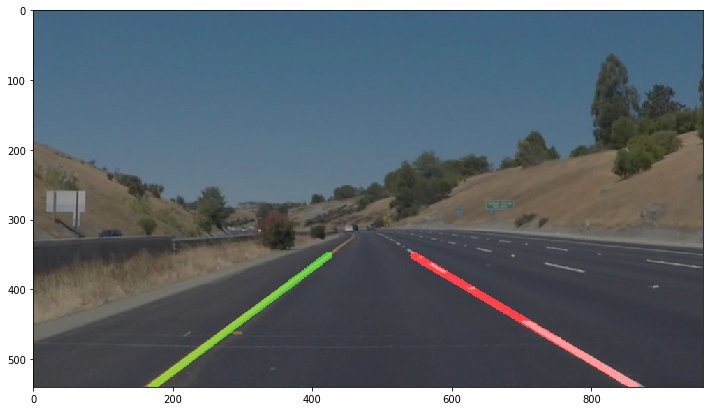

In [9]:
def average_of_lines(lines):
    left_line=[]
    right_line=[]
    left_length=[]
    right_length=[]
    for line in lines:
        for x1,y1,x2,y2 in line:   
            slope = ((y2-y1)/(x2-x1))
            intercept = y1 - slope*x1
            length = np.sqrt((x2-x1)**2-(y2-y1)**2)
            if slope <0 and slope <-0.4:
                left_line.append((slope, intercept))
                left_length.append((length))
            if slope > 0 and slope > 0.4:
                right_line.append((slope, intercept))
                right_length.append((length))
    # average of slopes and intercepts of the lines detected
    left_lane=np.mean(left_line,axis=0)
    right_lane=np.mean(right_line,axis=0)
    return left_lane, right_lane

def create_a_line(y1, y2, lane_line):
    """
    From slope and intercept calculated in draw_lines
    Generate X and Y data points
    """
    m, b = lane_line
    #where m is slope and b is intercept 
    x1 = int((y1 - b)/m)
    x2 = int((y2 - b)/m)
    y1 = int(y1)
    y2 = int(y2)
    return ((x1, y1), (x2, y2))

def lane_lines(image, lines):
    left_lane, right_lane = average_of_lines(lines)
    y1 = image.shape[0]
    y2 = y1*0.65
    left_line  = create_a_line(y1, y2, left_lane)
    right_line = create_a_line(y1, y2, right_lane)
    return left_line, right_line

def draw_left_lane_lines(image, lines, color=[0, 255, 0], thickness=10):
    # make a separate image to draw lines and combine with the orignal later
    blank_image = np.zeros_like(image)
    x=[]
    y=[]
    for line in lines:
        a,b=line
        x.append(a)
        y.append(b)
    cv2.line(blank_image, (x[0], y[0]), (x[1], y[1]), color, thickness)
    return cv2.addWeighted(image, 0.8, blank_image, 1, 0.0)

def draw_right_lane_lines(image, lines, color=[255, 0, 0], thickness=10):
    # make a separate image to draw lines and combine with the orignal later
    blank_image = np.zeros_like(image)
    x=[]
    y=[]
    for line in lines:
        a,b=line
        x.append(a)
        y.append(b)
    cv2.line(blank_image, (x[0], y[0]), (x[1], y[1]), color, thickness)
    return cv2.addWeighted(image, 0.8, blank_image, 1, 0.0)


# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)                                                                   
left_line, right_line = lane_lines(image,lines)
left_line=list(left_line)
right_line=list(right_line)
lane_det1=draw_left_lane_lines(image,left_line)
lane_det=(draw_right_lane_lines(lane_det1,right_line))
result = lane_det
fig = plt.figure(figsize=(12,13))
plt.imshow(result)
export_image = Image.fromarray(result)
export_image.save("readme_ref/result.jpeg")

The above output shows that the left lane is identified in green color and right lane in red. 

Since we have implemented all the steps on a given test image with yellow and white lines, lets try applying the same code on all test images.

## Start by display all the images from 'test_images/' folder

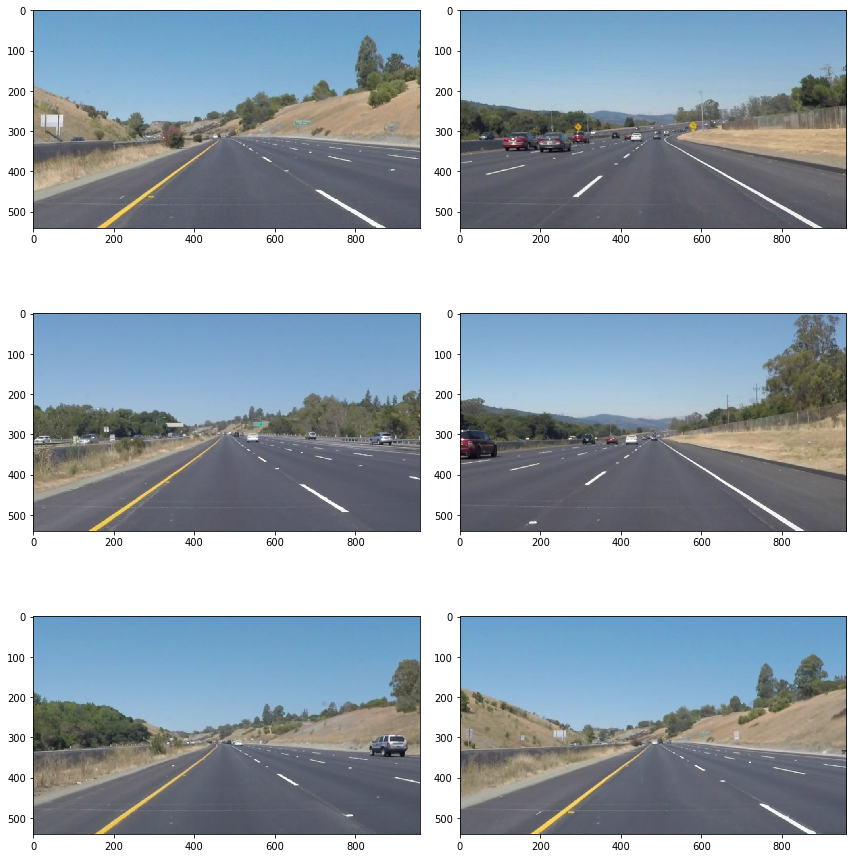

In [10]:
path=os.listdir("test_images/")
i=1
fig = plt.figure(figsize=(12,13))
for filename in path:
    if fnmatch.fnmatch(filename, '*.jpg'):
    #print("test_images/"+filename)
        image = mpimg.imread("test_images/"+filename)
        a=fig.add_subplot(3,2,i)
        plt.imshow(image)
        #print('This image is:', type(image), 'with dimensions:', image.shape)
        #printing out some stats and plotting
        i=i+1
plt.tight_layout()

## Building a Lane Finding Pipeline
### Implementing all the above steps in a single function (pipeline)

In [11]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    ###################################################################################
    ##Begin Pipeline##
    ###################################################################################
    ##Identify Yellow and White regions from the image##
    ###################################################################################
    colored_img = ident_white_yellow(image)
    ###################################################################################
    ##Convert the original image to grayscale##
    ###################################################################################
    gray = grayscale(colored_img)
    #fig = plt.figure()
    #a=fig.add_subplot(2,1,1)
    #plt.imshow(gray, cmap='gray')  
    # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray'
    ###################################################################################
    ##Apply Gaussian Smoothing to the gray scaled image##
    ###################################################################################
    kernel_size = 9
    blur_gray = gaussian_blur(gray,kernel_size)
    ###################################################################################
    ##Run Edge Detection Algorithm on the image##
    ###################################################################################
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)
    ###################################################################################
    ##Applying masking to regions of interest##
    ###################################################################################
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(425, 330), (525, 330), (imshape[1],imshape[0])]], dtype=np.int32)
    #vertices = np.array([[(250,650),(600, 500), (725, 450), (1100,650)]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)
    #a=fig.add_subplot(2,1,2)
    ###################################################################################
    ##Applying Hough Transform##
    ###################################################################################   
    rho = 1 #1 worked distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold =  35 # 15 and 35 worked    # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 50  #minimum number of pixels making up a line
    max_line_gap = 200    # maximum gap in pixels between connectable line segments
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)                                                                   
    lane_sketched = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)
    #plt.imshow(lane_sketched) 
    ###################################################################################
    ##Overlaying the detected lines on the original image##
    ###################################################################################
    #lane_det.append(draw_lane_lines(image, lane_lines(image,lines)))
    left_line, right_line = lane_lines(image,lines)
    left_line=list(left_line)
    right_line=list(right_line)
    lane_det1=draw_left_lane_lines(image,left_line)
    lane_det=(draw_right_lane_lines(lane_det1,right_line))
    result = lane_det
    return result

## Running the pipeline on all the Images in the directory "test_images"  
In an attempt to run this code multiple times, the input filenames are filtered with extension .jpg, while the processed images are saved as .jp**e**g. This prevents reprocessing of images already processed and helps avoid errors with a subplot of 2,3. Based on the output, it appears that both lanes have been correctly identified. The left lane is highlighted in green color and the right lane is highlighted in red color.
This helps in verifying that the pipeline is running correctly on all the test images.



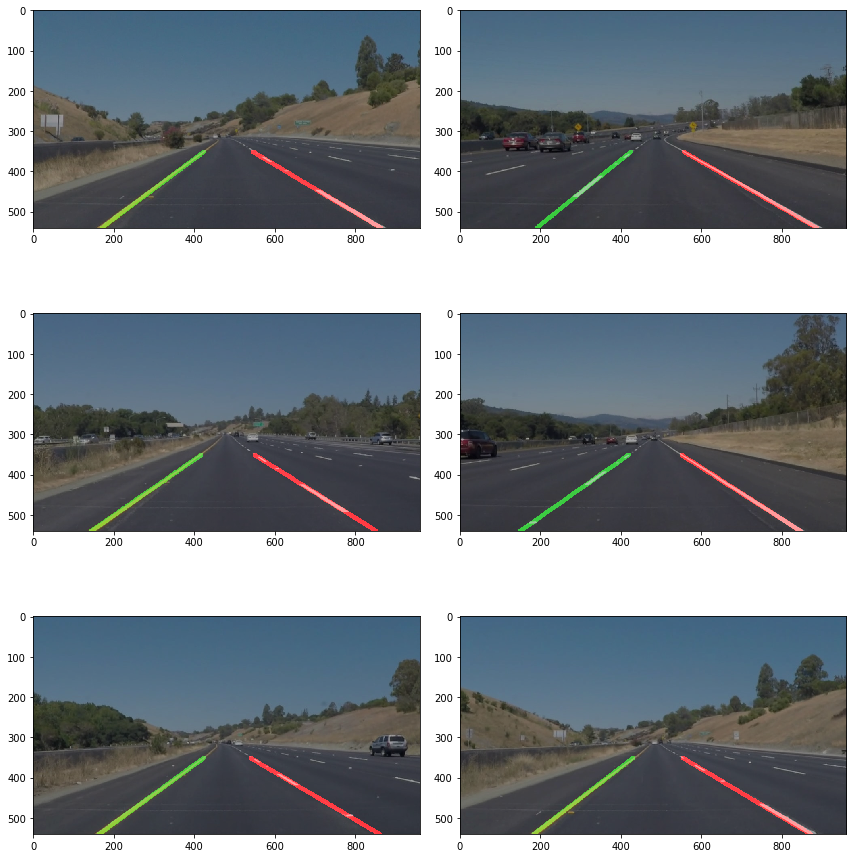

In [12]:
import os
os.listdir("test_images/")
i=1
fig = plt.figure(figsize=(12,13))
for filename in path:
    if fnmatch.fnmatch(filename, '*.jpg'):
        image = mpimg.imread("test_images/"+filename)
        lane_det=process_image(image)
        export_image = Image.fromarray(lane_det)
        export_image.save("test_images/"+filename[:-4]+"_processed.jpeg")
        a=fig.add_subplot(3,2,i)
        plt.imshow(lane_det) 
        i=i+1
plt.tight_layout()

## Running the pipeline on video files
Start with importing the dependencies to load and process the video files

In [13]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Running the pipeline on the videos
***

In [14]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:46<00:00,  4.69it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 1min 2s, sys: 1.06 s, total: 1min 3s
Wall time: 49.7 s


In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [16]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [02:29<00:00,  5.29it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 3min 15s, sys: 3 s, total: 3min 18s
Wall time: 2min 33s


In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

### The pipeline successfully identifies and annotates the lanes on the videos. Again, the left lane is highlighted in green and the right lane in red. This concludes the required part of the project


## Optional Challenge

In [18]:
def process_image_extra(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    ###################################################################################
    ##Begin Pipeline##
    ###################################################################################
    ##Identify Yellow and White regions from the image##
    ###################################################################################
    colored_img = ident_white_yellow(image)
    ###################################################################################
    ##Convert the original image to grayscale##
    ###################################################################################
    gray = grayscale(colored_img)
    #fig = plt.figure()
    #a=fig.add_subplot(2,1,1)
    #plt.imshow(gray, cmap='gray')  
    # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray'
    ###################################################################################
    ##Apply Gaussian Smoothing to the gray scaled image##
    ###################################################################################
    kernel_size = 9
    blur_gray = gaussian_blur(gray,kernel_size)
    ###################################################################################
    ##Run Edge Detection Algorithm on the image##
    ###################################################################################
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)
    ###################################################################################
    ##Applying masking to regions of interest##
    ###################################################################################
    imshape = image.shape
    #vertices = np.array([[(0,imshape[0]),(425, 330), (525, 330), (imshape[1],imshape[0])]], dtype=np.int32)
    vertices = np.array([[(250,650),(525, 450), (725, 450), (1100,650)]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)
    #a=fig.add_subplot(2,1,2)
    ###################################################################################
    ##Applying Hough Transform##
    ###################################################################################   
    rho = 1 #1 worked distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold =  15 # 15 and 35 worked    # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 40  #minimum number of pixels making up a line
    max_line_gap = 300    # maximum gap in pixels between connectable line segments
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)                                                                   
    lane_sketched = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)
    #plt.imshow(lane_sketched) 
    ###################################################################################
    ##Overlaying the detected lines on the original image##
    ###################################################################################
    #lane_det.append(draw_lane_lines(image, lane_lines(image,lines)))
    left_line, right_line = lane_lines(image,lines)
    left_line=list(left_line)
    right_line=list(right_line)
    lane_det1=draw_left_lane_lines(image,left_line)
    lane_det=(draw_right_lane_lines(lane_det1,right_line))
    result = lane_det
    return result

In [19]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image_extra)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [01:25<00:00,  3.26it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 1min 33s, sys: 1.76 s, total: 1min 35s
Wall time: 1min 32s


In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))